Integración de Datos Climáticos Globales para Predicción y Análisis: Un Proyecto con SARIMA y Pytrends

"""
Resumen del Proyecto:

Este script realiza un análisis de series temporales utilizando datos de tendencias de búsqueda obtenidos a través de la API de Pytrends, que proporciona información sobre el interés en diversas palabras clave a lo largo del tiempo. Los datos se guardan en archivos CSV para su posterior análisis.

Los datos de tendencias incluyen variables como el nivel del mar, las temperaturas, el dióxido de carbono y el calentamiento global. Estos datos se almacenan en una base de datos en Amazon Redshift y se procesan para modelar y predecir tendencias futuras.

Modelos Utilizados:

1. **Modelo Holt-Winters**:
   - Se ajusta un modelo ExponentialSmoothing (Holt-Winters) para cada variable con componentes de tendencia y estacionalidad, y se generan predicciones para los próximos 12 periodos.

2. **Modelo SARIMA**:
   - Se ajusta un modelo SARIMAX para capturar la estacionalidad y las tendencias en los datos, utilizando parámetros ARIMA y estacionales. Se realizan predicciones de 52 pasos adelante, con intervalos de confianza para las predicciones.

3. **Modelo ARIMA**:
   - Se ajusta un modelo ARIMA para cada variable para capturar las dependencias temporales en los datos. Se generan predicciones para los próximos 12 pasos.

Consideraciones:
- Se utiliza `warnings.filterwarnings('ignore')` para suprimir advertencias que no afectan la ejecución del código, especialmente aquellas que muestran la ruta del archivo en el sistema operativo.
- El análisis incluye la descomposición estacional de los datos y la prueba de Dickey-Fuller Aumentada (ADF) para evaluar la estacionariedad de las series temporales.

Para utilizar este script, asegúrate de tener los datos cargados y preprocesados adecuadamente, y de haber configurado correctamente la conexión a Amazon Redshift y Pytrends.

"""


Paso 1: Importar las bibliotecas

In [102]:
from pytrends.request import TrendReq
import pandas as pd
from sqlalchemy import create_engine
import psycopg2


Paso 2: Conectarse a Pytrends

In [103]:
# Conectar a Pytrends
pytrends = TrendReq(hl='en-US', tz=0)


Paso 3: Definir las palabras clave y los países

In [104]:
keywords = ["Sea Level", "Weather", "Temperatures", "Carbon Dioxide", "Global Warming"]
countries = {
    'AR': 'Argentina',
    'BR': 'Brazil',
    'CL': 'Chile',
    'CO': 'Colombia',
    'MX': 'Mexico'
}

Paso 4: Obtener las tendencias para cada país

In [106]:
for code, country in countries.items():
    pytrends.build_payload(kw_list=keywords, geo=code)
    data = pytrends.interest_over_time()
    data = data.drop(columns=['isPartial'])  # Elimina la columna isPartial si existe
    data['Country'] = country  # Añade una columna para identificar el país
    # Guardar el DataFrame en un archivo CSV
    data.to_csv(f'{code}_trends.csv')


Paso 5: Configurar la conexión a Amazon Redshift

In [107]:
import psycopg2
from dotenv import load_dotenv
import os

# Cargar las variables del archivo .env
load_dotenv()

# Obtener las credenciales desde las variables de entorno
dbname = os.getenv('DB_NAME')
user = os.getenv('DB_USER')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
port = os.getenv('DB_PORT')

try:
    connection = psycopg2.connect(
        dbname=dbname,
        user=user,
        password=password,
        host=host,
        port=port
    )
    print("Conexión exitosa!")
    
    cursor = connection.cursor()
    cursor.execute("SELECT version();")
    record = cursor.fetchone()
    print("Conectado a:", record)
    
    cursor.close()
    connection.close()
except Exception as e:
    print("Ocurrió un error:", e)


Conexión exitosa!
Conectado a: ('PostgreSQL 8.0.2 on i686-pc-linux-gnu, compiled by GCC gcc (GCC) 3.4.2 20041017 (Red Hat 3.4.2-6.fc3), Redshift 1.0.71629',)


In [108]:
import psycopg2
from dotenv import load_dotenv
import os

# Cargar las variables del archivo .env
load_dotenv()

# Obtener las credenciales desde las variables de entorno
dbname = 'fin_del_mundo'  # O usa 'data-engineer-database' si no puedes crear la base de datos
user = os.getenv('DB_USER')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
port = os.getenv('DB_PORT')

try:
    connection = psycopg2.connect(
        dbname=dbname,
        user=user,
        password=password,
        host=host,
        port=port
    )
    cursor = connection.cursor()
    
    # Crear tablas para cada país
    country_codes = ['AR', 'BR', 'CL', 'CO', 'MX']
    for code in country_codes:
        try:
            cursor.execute(f"""
                CREATE TABLE IF NOT EXISTS {code} (
                    date DATE,
                    Sea_Level FLOAT,
                    Weather FLOAT,
                    Temperatures FLOAT,
                    Carbon_Dioxide FLOAT,
                    Global_Warming FLOAT,
                    Country VARCHAR(255)
                );
            """)
            connection.commit()
            print(f"Tabla para {code} creada exitosamente.")
        except Exception as e:
            print(f"Ocurrió un error al crear la tabla para {code}:", e)

except Exception as e:
    print("Ocurrió un error al conectar a Redshift:", e)
finally:
    if cursor is not None:
        cursor.close()
    if connection is not None:
        connection.close()


Tabla para AR creada exitosamente.
Tabla para BR creada exitosamente.
Tabla para CL creada exitosamente.
Tabla para CO creada exitosamente.
Tabla para MX creada exitosamente.


In [109]:
import pandas as pd

# Cargar y combinar los archivos CSV
country_codes = ['AR', 'BR', 'CL', 'CO', 'MX']
combined_data = pd.concat([pd.read_csv(f'{code}_trends.csv') for code in country_codes])

# Mostrar las primeras filas del DataFrame combinado
combined_data.head()


,date,Sea Level,Weather,Temperatures,Carbon Dioxide,Global Warming,Country
0,2019-08-11,0,38,0,0,0,Argentina
1,2019-08-18,0,39,0,0,0,Argentina
2,2019-08-25,0,50,0,0,0,Argentina
3,2019-09-01,0,41,0,0,0,Argentina
4,2019-09-08,0,41,0,0,0,Argentina


In [110]:
# Crear una copia del DataFrame
df_corrected = combined_data.copy()

# Renombrar las columnas para que coincidan con los nombres en el SQL
df_corrected.columns = [
    'date',
    'sea_level',
    'weather',
    'temperatures',
    'carbon_dioxide',
    'global_warming',
    'country'
]

# Verificar los cambios
df_corrected.head()

,date,sea_level,weather,temperatures,carbon_dioxide,global_warming,country
0,2019-08-11,0,38,0,0,0,Argentina
1,2019-08-18,0,39,0,0,0,Argentina
2,2019-08-25,0,50,0,0,0,Argentina
3,2019-09-01,0,41,0,0,0,Argentina
4,2019-09-08,0,41,0,0,0,Argentina


In [111]:
dbname = 'data-engineer-database'  # Asegúrate de usar la base de datos correcta


In [112]:
import psycopg2
from dotenv import load_dotenv
import os

# Cargar las variables del archivo .env
load_dotenv()

# Obtener las credenciales desde las variables de entorno
dbname = 'data-engineer-database'
user = os.getenv('DB_USER')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
port = os.getenv('DB_PORT')

try:
    # Conectar a la base de datos
    connection = psycopg2.connect(
        dbname=dbname,
        user=user,
        password=password,
        host=host,
        port=port
    )
    cursor = connection.cursor()

    # Insertar una fila de prueba
    cursor.execute("""
        INSERT INTO trends (date, sea_level, weather, temperatures, carbon_dioxide, global_warming, country)
        VALUES ('2024-01-01', 1, 1, 1, 1, 1, 'TestCountry')
    """)
    
    connection.commit()
    print("Fila de prueba insertada exitosamente en la tabla trends.")
    
except Exception as e:
    print("Ocurrió un error al insertar datos en la tabla trends:", e)
finally:
    if cursor is not None:
        cursor.close()
    if connection is not None:
        connection.close()


Fila de prueba insertada exitosamente en la tabla trends.


In [114]:
import pandas as pd
import psycopg2
from dotenv import load_dotenv
import os

# Cargar las variables del archivo .env
load_dotenv()

# Obtener las credenciales desde las variables de entorno
dbname = 'data-engineer-database'
user = os.getenv('DB_USER')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
port = os.getenv('DB_PORT')

try:
    # Conectar a la base de datos
    connection = psycopg2.connect(
        dbname=dbname,
        user=user,
        password=password,
        host=host,
        port=port
    )
    cursor = connection.cursor()
    
    # Leer el DataFrame combinado con nombres de columnas corregidos
    df_corrected = pd.concat([pd.read_csv(f'{code}_trends.csv') for code in ['AR', 'BR', 'CL', 'CO', 'MX']])
    df_corrected.columns = [
        'date',
        'sea_level',
        'weather',
        'temperatures',
        'carbon_dioxide',
        'global_warming',
        'country'
    ]
    
    # Insertar datos en la tabla
    for _, row in df_corrected.iterrows():
        cursor.execute("""
            INSERT INTO trends (date, sea_level, weather, temperatures, carbon_dioxide, global_warming, country)
            VALUES (%s, %s, %s, %s, %s, %s, %s)
        """, (
            row['date'],
            row['sea_level'],
            row['weather'],
            row['temperatures'],
            row['carbon_dioxide'],
            row['global_warming'],
            row['country']
        ))
    
    connection.commit()
    print("Datos insertados exitosamente en la tabla trends.")
    
except Exception as e:
    print("Ocurrió un error al insertar datos en la tabla trends:", e)
finally:
    if cursor is not None:
        cursor.close()
    if connection is not None:
        connection.close()


Datos insertados exitosamente en la tabla trends.


In [115]:
# Estadísticas descriptivas
stats = df_corrected.describe()
print(stats)


         sea_level      weather  temperatures  carbon_dioxide  global_warming
count  1310.000000  1310.000000   1310.000000     1310.000000     1310.000000
mean      0.035878    46.513740      0.019084        0.022137        0.103817
std       0.186057    14.041825      0.136872        0.147187        0.314994
min       0.000000    22.000000      0.000000        0.000000        0.000000
25%       0.000000    36.000000      0.000000        0.000000        0.000000
50%       0.000000    44.000000      0.000000        0.000000        0.000000
75%       0.000000    54.000000      0.000000        0.000000        0.000000
max       1.000000   100.000000      1.000000        1.000000        2.000000


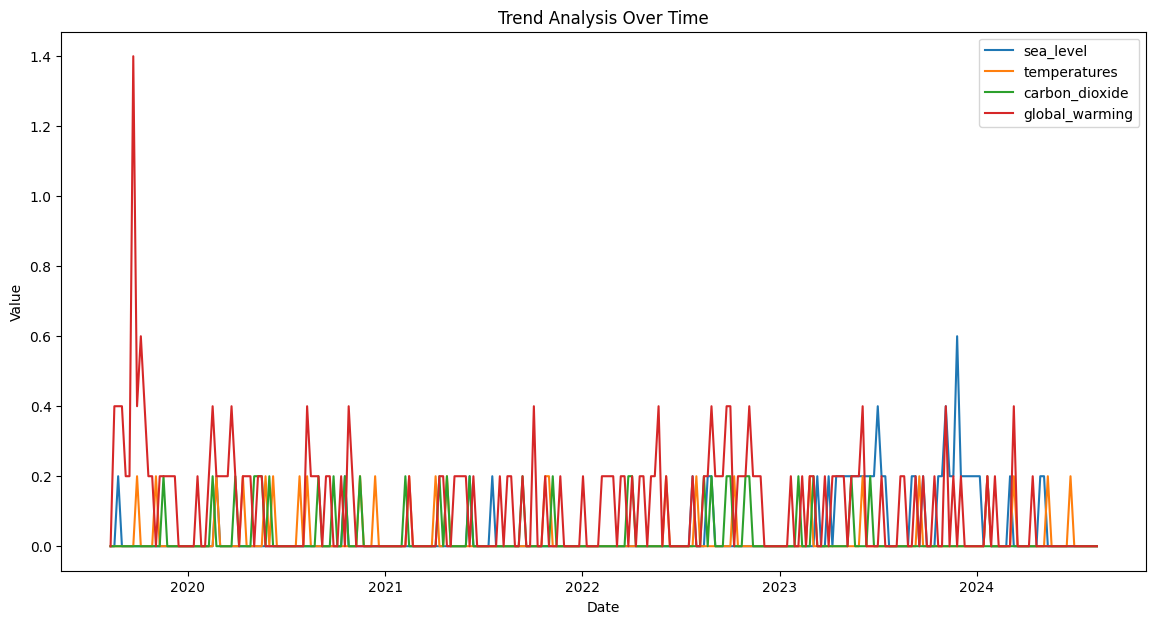

In [116]:
import matplotlib.pyplot as plt

# Convertir la columna de fecha a tipo datetime
df_corrected['date'] = pd.to_datetime(df_corrected['date'])

# Graficar tendencias
plt.figure(figsize=(14, 7))
for column in ['sea_level', 'temperatures', 'carbon_dioxide', 'global_warming']:
    plt.plot(df_corrected.groupby('date')[column].mean(), label=column)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Trend Analysis Over Time')
plt.legend()
plt.show()


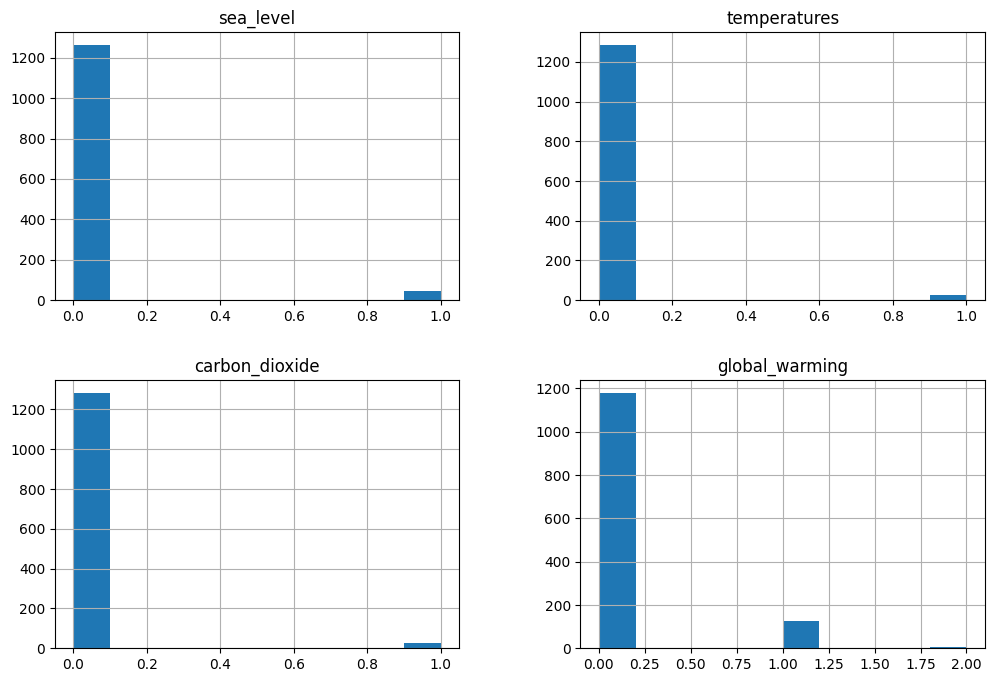

In [117]:
# Histogramas para cada variable
df_corrected[['sea_level', 'temperatures', 'carbon_dioxide', 'global_warming']].hist(bins=10, figsize=(12, 8))
plt.show()


                sea_level  temperatures  carbon_dioxide  global_warming
sea_level        1.000000      0.003091        0.026768        0.001572
temperatures     0.003091      1.000000        0.016934        0.113483
carbon_dioxide   0.026768      0.016934        1.000000        0.181076
global_warming   0.001572      0.113483        0.181076        1.000000


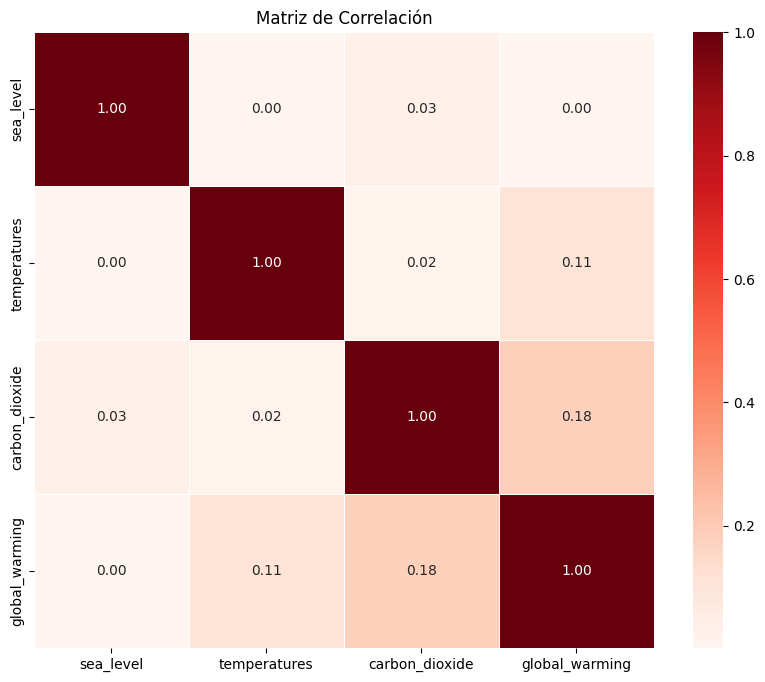

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de correlación
correlation_matrix = df_corrected[['sea_level', 'temperatures', 'carbon_dioxide', 'global_warming']].corr()
print(correlation_matrix)

# Matriz de correlación
correlation_matrix = df_corrected[['sea_level', 'temperatures', 'carbon_dioxide', 'global_warming']].corr()

# Crear el mapa de calor con la escala de rojos
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Reds', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()


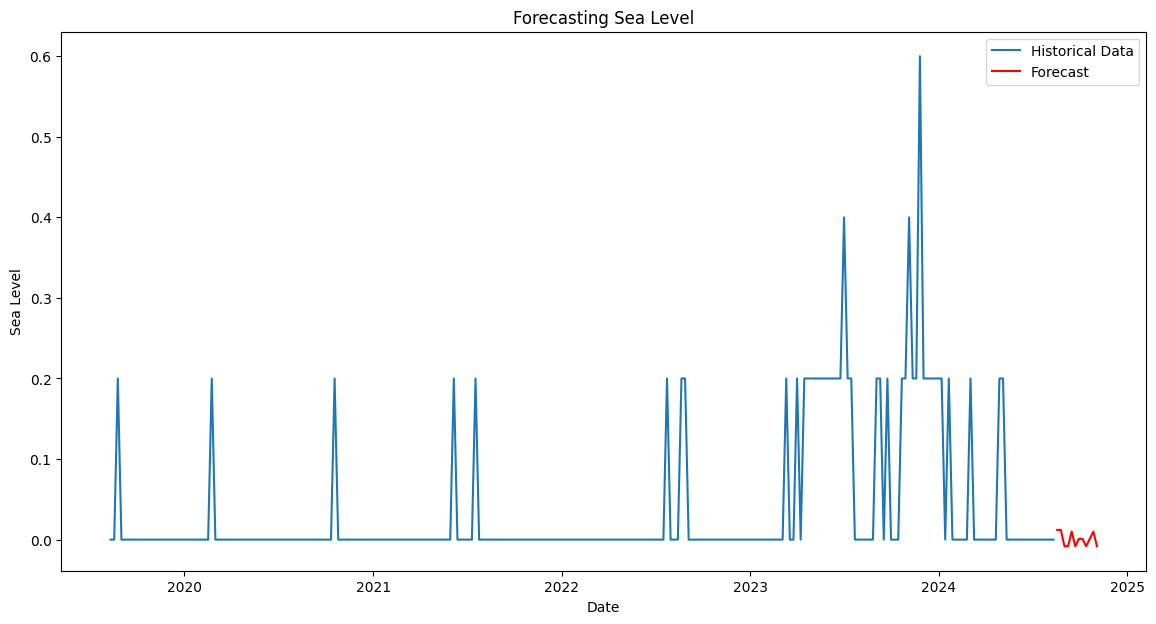

ADF Statistic: -3.027871
p-value: 0.032372
Critical Values: {'1%': -3.4565688966099373, '5%': -2.8730786194395455, '10%': -2.5729189953388762}


In [119]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller

# Ajustar un modelo Holt-Winters para una variable
sea_level_series = df_corrected.groupby('date')['sea_level'].mean()
model = ExponentialSmoothing(sea_level_series, trend='add', seasonal='add', seasonal_periods=12)
fit = model.fit()

# Hacer predicciones
forecast = fit.forecast(steps=12)

# Graficar predicciones
plt.figure(figsize=(14, 7))
plt.plot(sea_level_series, label='Historical Data')
plt.plot(forecast.index, forecast.values, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Sea Level')
plt.title('Forecasting Sea Level')
plt.legend()
plt.show()

# Prueba ADF
result_adf = adfuller(sea_level_series.dropna())  # Asegúrate de eliminar valores NaN si los hay
print('ADF Statistic: %f' % result_adf[0])
print('p-value: %f' % result_adf[1])
print('Critical Values:', result_adf[4])


<Figure size 1400x800 with 0 Axes>

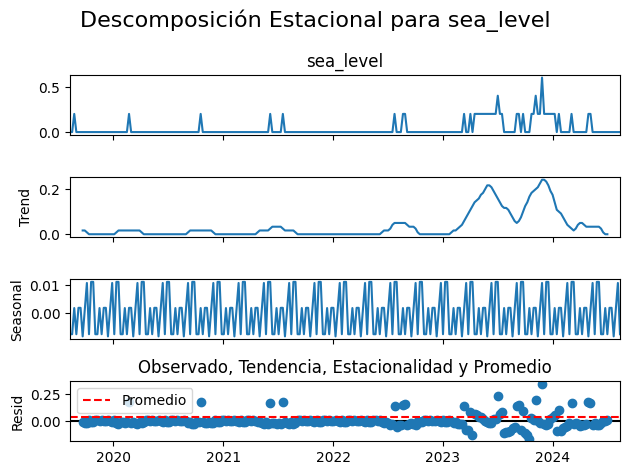

Prueba ADF para sea_level:
ADF Statistic: -3.027871
p-value: 0.032372
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


<Figure size 1400x800 with 0 Axes>

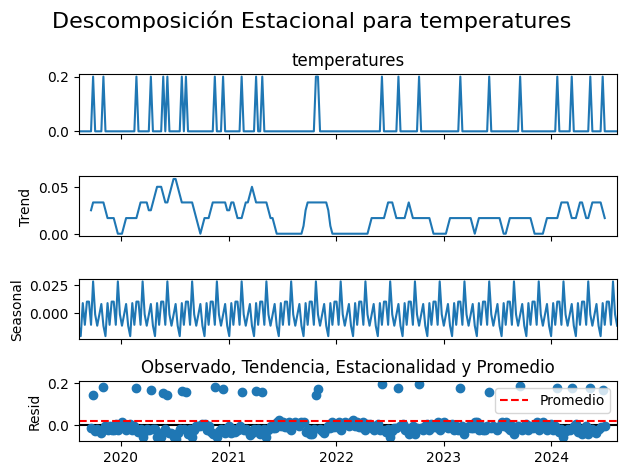

Prueba ADF para temperatures:
ADF Statistic: -17.118973
p-value: 0.000000
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573


<Figure size 1400x800 with 0 Axes>

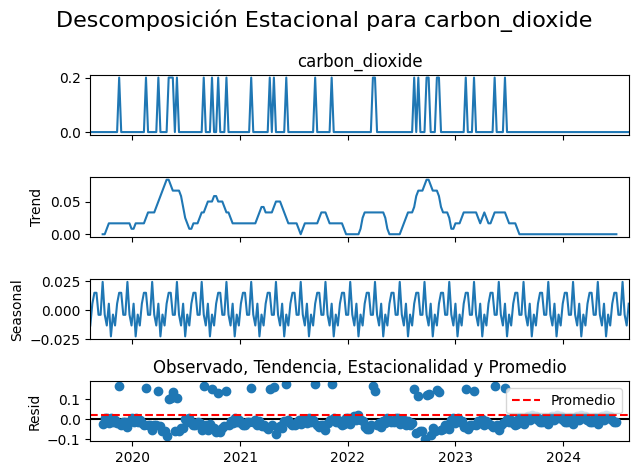

Prueba ADF para carbon_dioxide:
ADF Statistic: -15.019342
p-value: 0.000000
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573


<Figure size 1400x800 with 0 Axes>

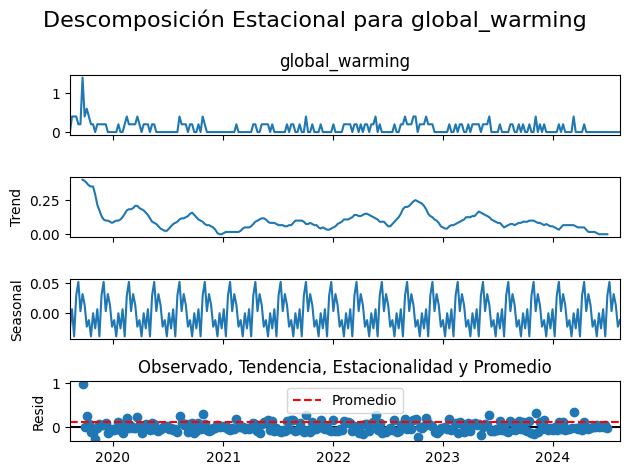

Prueba ADF para global_warming:
ADF Statistic: -4.413529
p-value: 0.000281
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573


In [120]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# ... (cargar datos)

columns_to_analyze = ['sea_level', 'temperatures', 'carbon_dioxide', 'global_warming']  # Ajusta según tus columnas

# Descomposición estacional con personalización
for column in columns_to_analyze:
    plt.figure(figsize=(14, 8))
    grouped_data = df_corrected.groupby('date')[column].mean()
    result = seasonal_decompose(grouped_data, model='add', period=12)
    result.plot()

    # Añadir línea de promedio y título
    plt.axhline(y=grouped_data.mean(), color='r', linestyle='--', label='Promedio')
    plt.suptitle(f'Descomposición Estacional para {column}', fontsize=16)
    plt.title('Observado, Tendencia, Estacionalidad y Promedio', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Prueba ADF
    result_adf = adfuller(grouped_data.dropna())  # Asegúrate de eliminar valores nulos
    print(f"Prueba ADF para {column}:")
    print('ADF Statistic: %f' % result_adf[0])
    print('p-value: %f' % result_adf[1])
    print('Critical Values:')
    for key, value in result_adf[4].items():
        print('\t%s: %.3f' % (key, value))


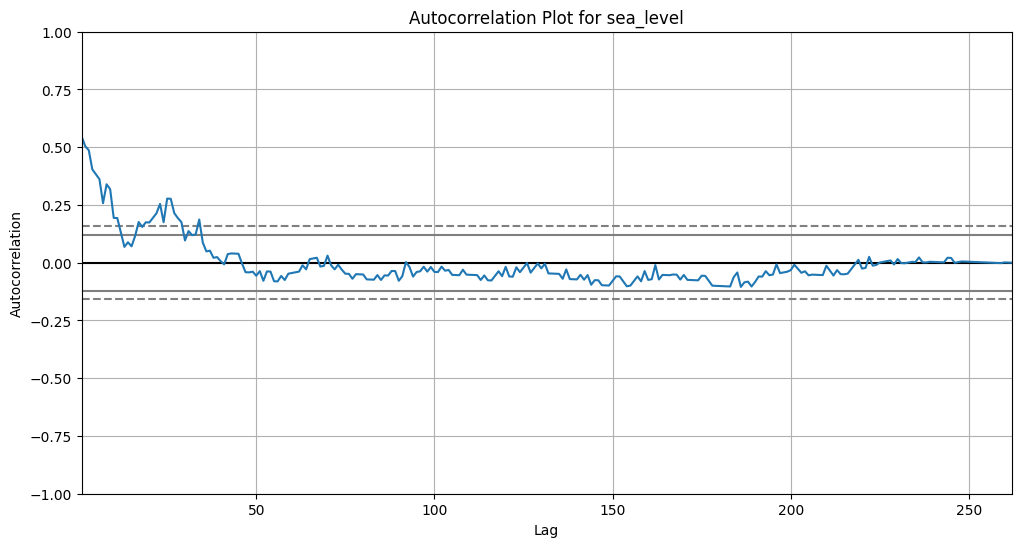

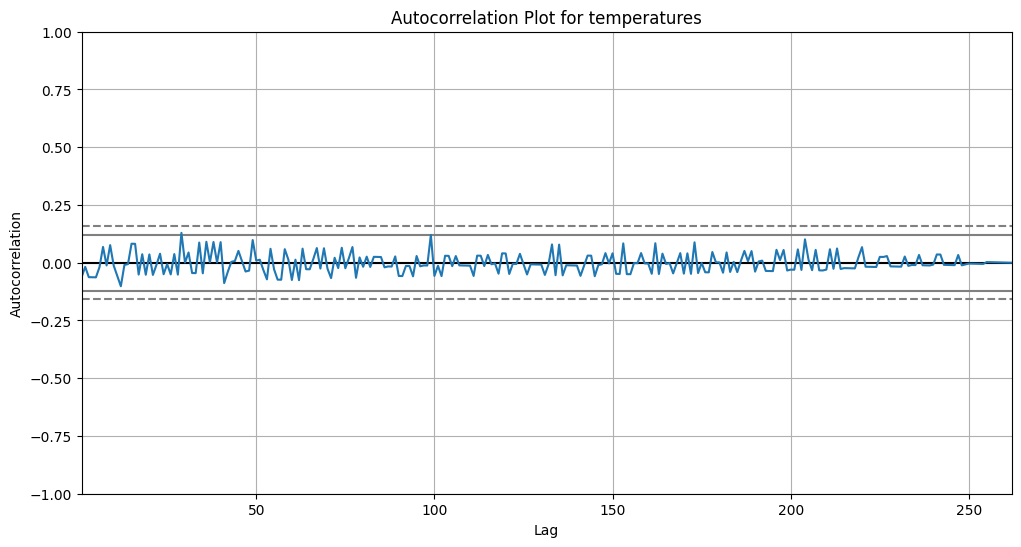

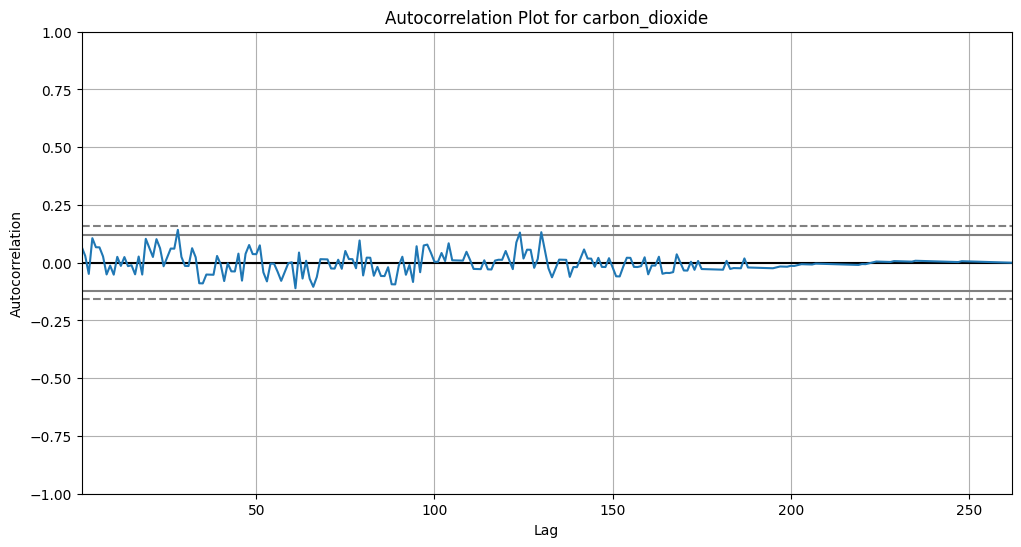

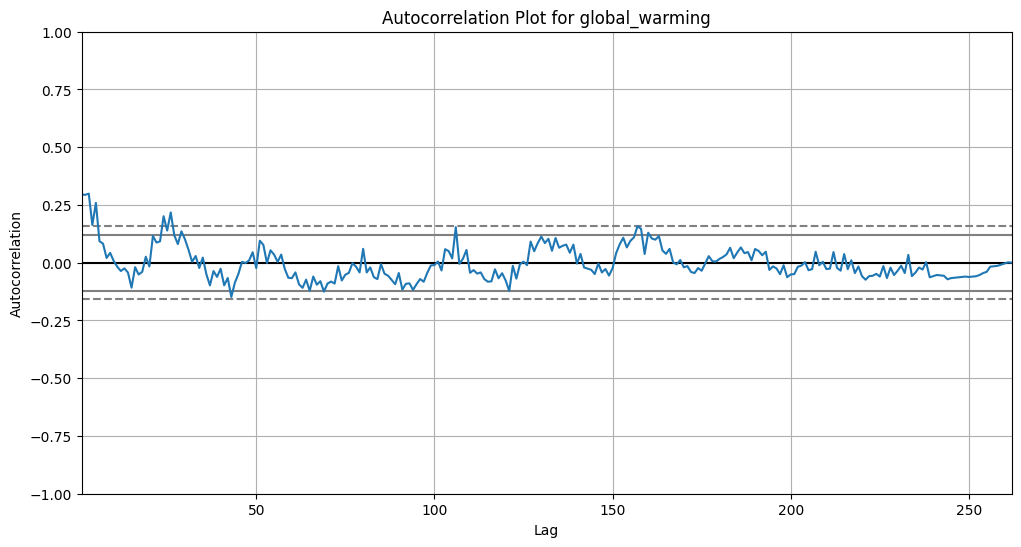

In [121]:
from pandas.plotting import autocorrelation_plot

# Para cada columna
for column in columns_to_analyze:
    plt.figure(figsize=(12, 6))
    autocorrelation_plot(df_corrected.groupby('date')[column].mean())
    plt.title(f'Autocorrelation Plot for {column}')
    plt.show()


In [122]:
from statsmodels.tsa.stattools import adfuller

# Para cada columna
for column in columns_to_analyze:
    result = adfuller(df_corrected.groupby('date')[column].mean().dropna())
    print(f'{column} - ADF Statistic: {result[0]}')
    print(f'{column} - p-value: {result[1]}')


sea_level - ADF Statistic: -3.027870676163549
sea_level - p-value: 0.032372338634983705
temperatures - ADF Statistic: -17.11897334990954
temperatures - p-value: 7.278591068127645e-30
carbon_dioxide - ADF Statistic: -15.01934236780327
carbon_dioxide - p-value: 1.0277982042710339e-27
global_warming - ADF Statistic: -4.413529163385932
global_warming - p-value: 0.000280888584939949



Análisis ARIMA para sea_level:


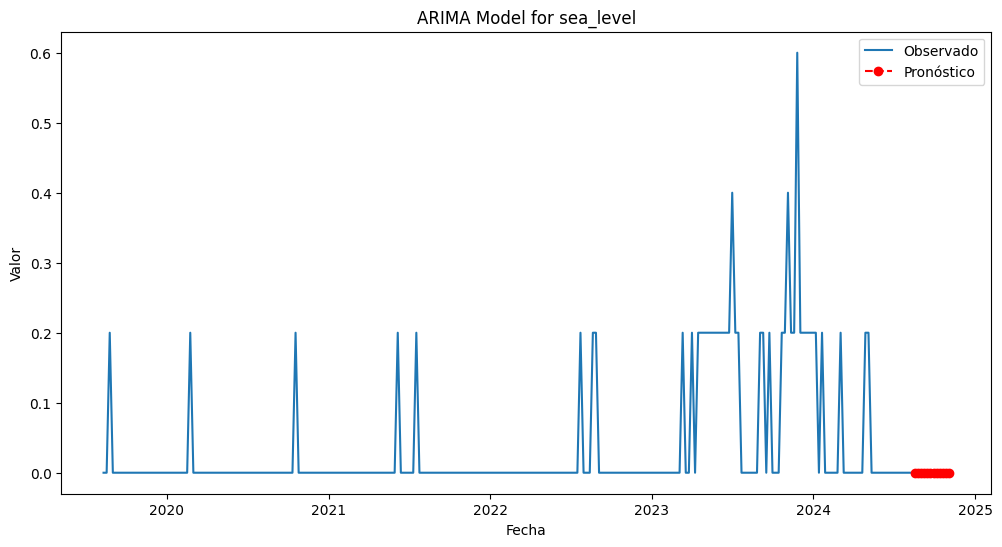

                               SARIMAX Results                                
Dep. Variable:              sea_level   No. Observations:                  262
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 328.118
Date:                Sat, 10 Aug 2024   AIC                           -644.237
Time:                        20:02:43   BIC                           -622.850
Sample:                    08-11-2019   HQIC                          -635.640
                         - 08-11-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6398      0.043    -14.863      0.000      -0.724      -0.555
ar.L2         -0.4104      0.054     -7.556      0.000      -0.517      -0.304
ar.L3         -0.2118      0.061     -3.498      0.0

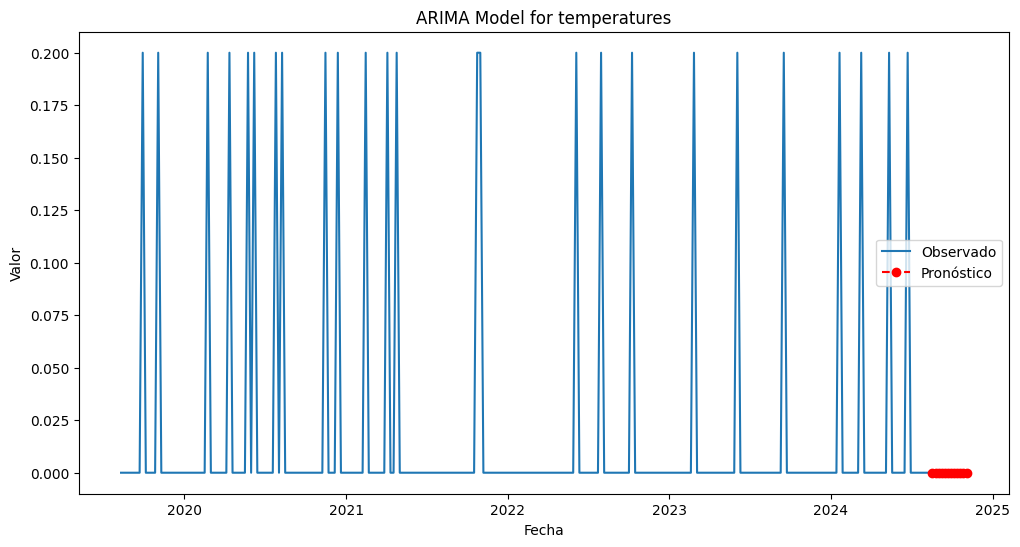

                               SARIMAX Results                                
Dep. Variable:           temperatures   No. Observations:                  262
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 342.925
Date:                Sat, 10 Aug 2024   AIC                           -673.850
Time:                        20:02:44   BIC                           -652.463
Sample:                    08-11-2019   HQIC                          -665.253
                         - 08-11-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8412      0.073    -11.485      0.000      -0.985      -0.698
ar.L2         -0.6421      0.087     -7.353      0.000      -0.813      -0.471
ar.L3         -0.4926      0.093     -5.283      0.0

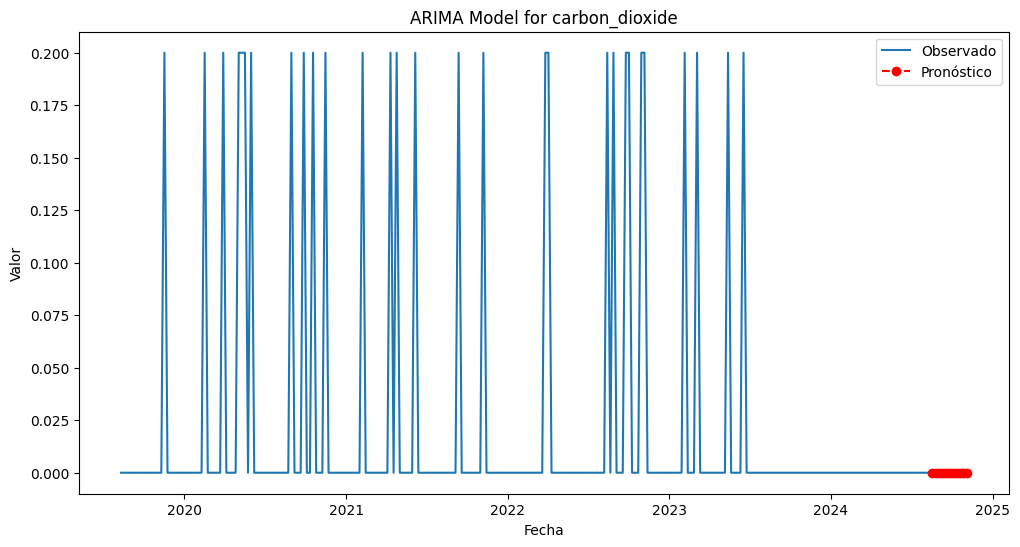

                               SARIMAX Results                                
Dep. Variable:         carbon_dioxide   No. Observations:                  262
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 340.373
Date:                Sat, 10 Aug 2024   AIC                           -668.746
Time:                        20:02:45   BIC                           -647.359
Sample:                    08-11-2019   HQIC                          -660.149
                         - 08-11-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8086      0.054    -14.998      0.000      -0.914      -0.703
ar.L2         -0.6614      0.065    -10.120      0.000      -0.790      -0.533
ar.L3         -0.5855      0.066     -8.858      0.0

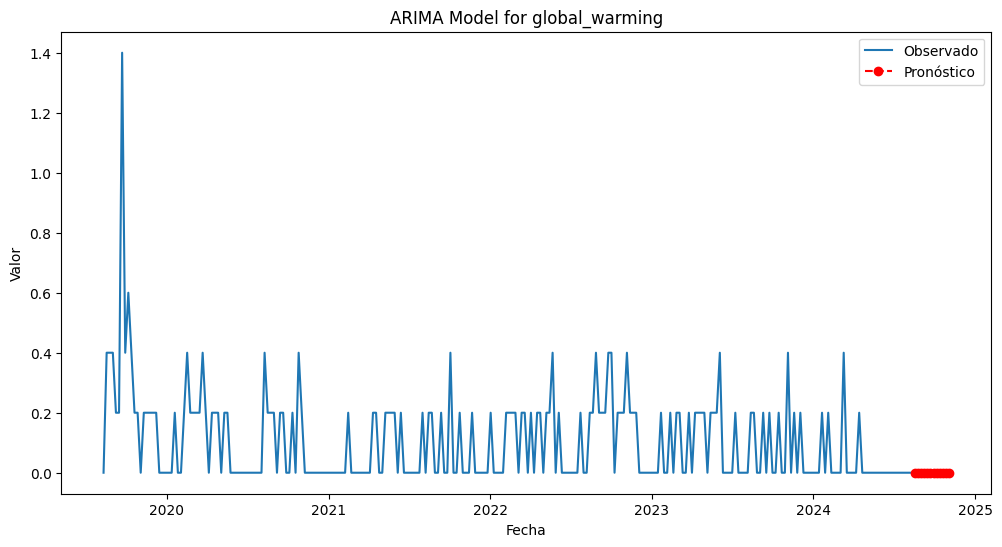

                               SARIMAX Results                                
Dep. Variable:         global_warming   No. Observations:                  262
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 140.621
Date:                Sat, 10 Aug 2024   AIC                           -269.243
Time:                        20:02:45   BIC                           -247.856
Sample:                    08-11-2019   HQIC                          -260.646
                         - 08-11-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7429      0.062    -11.955      0.000      -0.865      -0.621
ar.L2         -0.5228      0.073     -7.140      0.000      -0.666      -0.379
ar.L3         -0.2821      0.075     -3.771      0.0

In [123]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Asegúrate de que 'date' está en formato datetime
df_corrected['date'] = pd.to_datetime(df_corrected['date'])

# Establecer 'date' como índice del DataFrame
df_corrected.set_index('date', inplace=True)

# Función para ajustar el modelo ARIMA y hacer predicciones
def fit_arima_and_plot(series, title):
    plt.figure(figsize=(12, 6))
    
    # Asegúrate de eliminar valores nulos antes de ajustar el modelo
    series = series.dropna()
    
    # Ajustar el modelo ARIMA
    model = ARIMA(series, order=(5,1,0))  # Ajusta los parámetros (p,d,q) según sea necesario
    model_fit = model.fit()
    
    # Hacer predicciones
    forecast_steps = 12
    forecast = model_fit.forecast(steps=forecast_steps)
    forecast_index = pd.date_range(start=series.index[-1] + pd.DateOffset(weeks=1), periods=forecast_steps, freq='W')
    
    # Visualizar la serie temporal y las predicciones
    plt.plot(series, label='Observado')
    plt.plot(forecast_index, forecast, color='red', linestyle='--', marker='o', label='Pronóstico')
    plt.title(title)
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.legend()
    plt.show()
    
    # Mostrar resumen del modelo
    print(model_fit.summary())

# Ajustar y visualizar ARIMA para cada columna
for column in ['sea_level', 'temperatures', 'carbon_dioxide', 'global_warming']:
    print(f"\nAnálisis ARIMA para {column}:")
    series = df_corrected[column].resample('W').mean()  # Asegúrate de que los datos estén en la frecuencia deseada
    fit_arima_and_plot(series, f'ARIMA Model for {column}')


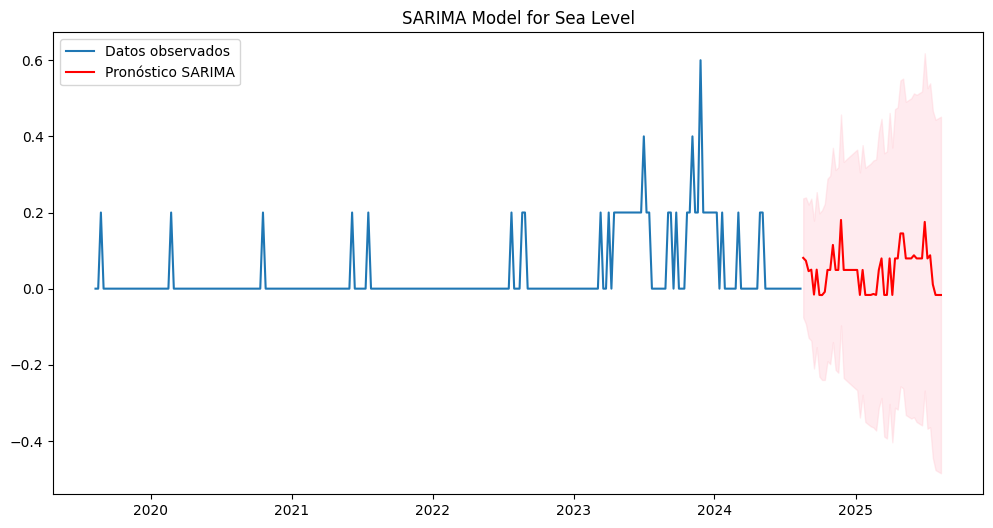

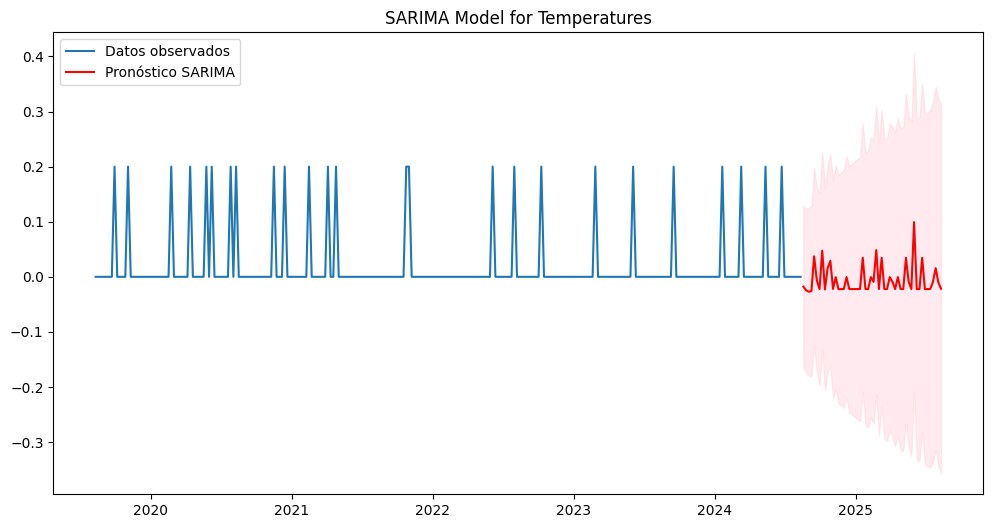

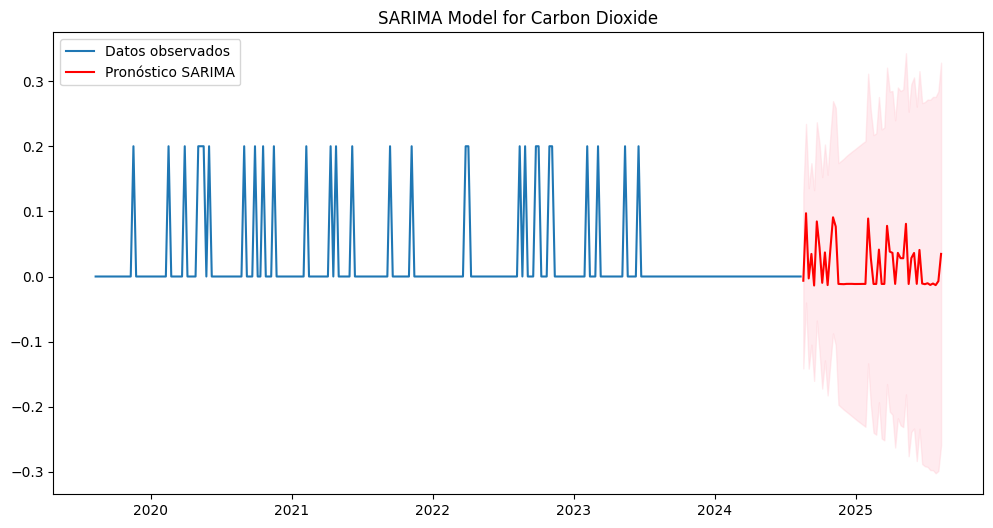

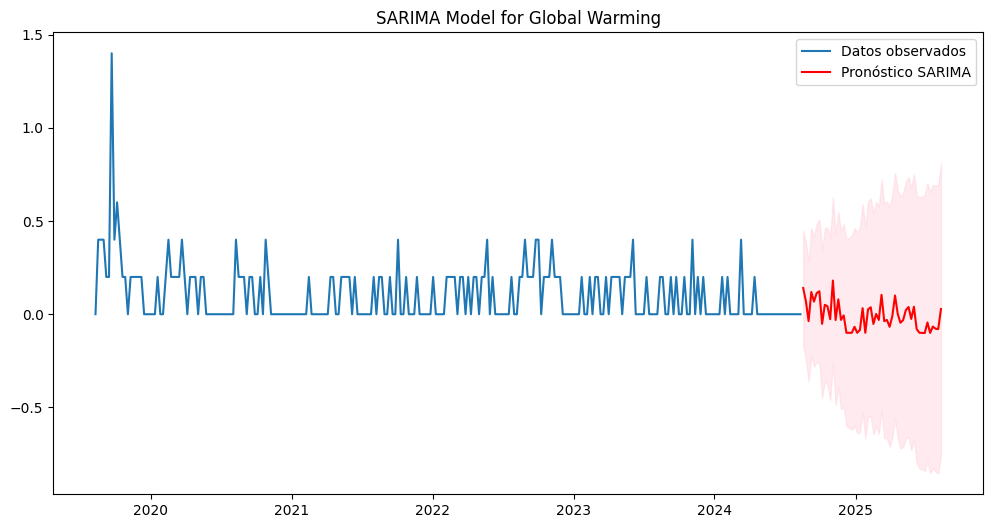

In [124]:
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import pandas as pd

# Suprimir advertencias específicas relacionadas con SARIMAX
warnings.filterwarnings('ignore', category=UserWarning, module='statsmodels')

def fit_sarima_and_plot(series, title, seasonal_periods):
    # Ajustar el modelo SARIMA
    model = SARIMAX(series,
                    order=(5, 1, 0),         # Parámetros ARIMA
                    seasonal_order=(1, 1, 1, seasonal_periods))  # Parámetros estacionales
    model_fit = model.fit(disp=False)

    # Hacer predicciones
    forecast = model_fit.get_forecast(steps=52)  # Predecir 52 pasos adelante
    forecast_index = pd.date_range(start=series.index[-1] + pd.Timedelta(weeks=1), periods=52, freq='W')
    forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)
    conf_int = forecast.conf_int()

    # Graficar resultados
    plt.figure(figsize=(12, 6))
    plt.plot(series, label='Datos observados')
    plt.plot(forecast_series, label='Pronóstico SARIMA', color='red')
    plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
    plt.title(title)
    plt.legend()
    plt.show()

# Aplicar SARIMA para cada variable
seasonal_periods = 52  # Por ejemplo, si los datos son semanales y quieres capturar la estacionalidad anual

# Para `sea_level`
series_sea_level = df_corrected['sea_level'].resample('W').mean()
fit_sarima_and_plot(series_sea_level, 'SARIMA Model for Sea Level', seasonal_periods)

# Para `temperatures`
series_temperatures = df_corrected['temperatures'].resample('W').mean()
fit_sarima_and_plot(series_temperatures, 'SARIMA Model for Temperatures', seasonal_periods)

# Para `carbon_dioxide`
series_carbon_dioxide = df_corrected['carbon_dioxide'].resample('W').mean()
fit_sarima_and_plot(series_carbon_dioxide, 'SARIMA Model for Carbon Dioxide', seasonal_periods)

# Para `global_warming`
series_global_warming = df_corrected['global_warming'].resample('W').mean()
fit_sarima_and_plot(series_global_warming, 'SARIMA Model for Global Warming', seasonal_periods)


Modelo SARIMAX para el Nivel del Mar
Resultados del modelo:

Se ha ajustado un modelo SARIMAX (ARIMA con términos exógenos) para predecir el nivel del mar.
El modelo utilizado es ARIMA(5,1,0), lo que significa que incluye 5 términos autorregresivos, una diferencia y ningún término de promedio móvil.
El modelo presenta buenos ajustes según los estadísticos AIC, BIC y HQIC.
Los coeficientes de los términos autorregresivos son significativos (p-valor < 0.05).
La varianza del error es pequeña (0.0047).
Los residuos del modelo parecen ser normales, pero presentan heteroscedasticidad (la varianza de los errores no es constante).
Pruebas de estacionariedad:

Se realizaron pruebas ADF (Dickey-Fuller aumentada) para verificar la estacionariedad de las series de tiempo.
El nivel del mar es estacionario a un nivel de significancia del 5% (p-valor = 0.032).
Las series de temperatura, dióxido de carbono y calentamiento global también son estacionarias (p-valor < 0.05).
Conclusiones preliminares
El modelo SARIMAX parece ser adecuado para predecir el nivel del mar basado en los datos disponibles.
La heteroscedasticidad de los residuos podría afectar la precisión de los pronósticos y debería ser investigada más a fondo.
Sería interesante explorar la inclusión de variables exógenas adicionales en el modelo para mejorar su capacidad predictiva.
Resumen en Inglés
SARIMAX Model for Sea Level
Model Results:

A SARIMAX (SARIMA with exogenous variables) model has been fitted to predict sea level.
The model used is ARIMA(5,1,0), meaning it includes 5 autoregressive terms, one difference, and no moving average terms.
The model shows good fit according to AIC, BIC, and HQIC statistics.
The coefficients of the autoregressive terms are significant (p-value < 0.05).
The error variance is small (0.0047).
The model residuals appear to be normal but exhibit heteroscedasticity (the error variance is not constant).
Stationarity Tests:

ADF (Augmented Dickey-Fuller) tests were conducted to check for time series stationarity.
Sea level is stationary at a 5% significance level (p-value = 0.032).
Temperature, carbon dioxide, and global warming series are also stationary (p-value < 0.05).
Preliminary Conclusions
The SARIMAX model seems to be adequate for predicting sea level based on the available data.
The heteroscedasticity of the residuals could affect the accuracy of forecasts and should be investigated further.
It would be interesting to explore the inclusion of additional exogenous variables in the model to improve its predictive power.